In [271]:
import imports as ii
import functions as f
import preprocessing as pp
import neuralnetworks as nn 

In [272]:
PATH = {}
PATH["dataset_classification"] = "dataset/classification/"
PATH["dataset_labeling"] = "dataset/seq_labeling/"
PATH["music_reviews_train"] = PATH["dataset_classification"] + "music_reviews_train.json.gz"
PATH["music_reviews_dev"] = PATH["dataset_classification"] + "music_reviews_dev.json.gz"
PATH["music_reviews_test"] = PATH["dataset_classification"] + "music_reviews_test_masked.json.gz"
train = f.readJson(PATH["music_reviews_train"])
test = f.readJson(PATH["music_reviews_dev"])

Number of data:  100000
Number of data:  10000


In [273]:
X_train, y_train, train_idx, train_missing_idx = f.json_divide(train)
X_test, y_test, test_idx, test_missing_idx = f.json_divide(test)

# convert labels
sent_dict = {"positive": 1, "negative": 0}
y_train = pp.sentiment_converter(y_train, sent_dict)
y_test = pp.sentiment_converter(y_test, sent_dict)

In [274]:
# hack
end = 30000
start = 100
X_train = X_train[start:end+start]
y_train = y_train[start:end+start]
X_test = X_test[start:end+start]
y_test = y_test[start:end+start]

## PREPROCESSING FUNCTIONS

In [116]:
# simplyfy contractions
train_set_clean = f.simplify_contraction(X_train)
test_set_clean = f.simplify_contraction(X_test)

# BASIC PREPROCESSING
train_set_clean = pp.basic_preprocess(train_set_clean)
test_set_clean = pp.basic_preprocess(test_set_clean)

# GRAMMAR CORRECTOR 
train_set_clean = pp.grammar_corrector(train_set_clean)
test_set_clean  = pp.grammar_corrector(test_set_clean)

# lemmattize 
train_set_clean = pp.lemmatize_sentencelist(train_set_clean)
test_set_clean = pp.lemmatize_sentencelist(test_set_clean)

# REMOVE STOP WORDS
train_set_clean = pp.remove_stop_words(train_set_clean)
test_set_clean = pp.remove_stop_words(test_set_clean)

## Neural Network INIT

In [89]:
# Tokenizer
tokenizer = pp.tokenizer_init(train_set_clean, test_set_clean)
Train = tokenizer.texts_to_sequences(train_set_clean)
Test = tokenizer.texts_to_sequences(test_set_clean)
# Sequencer 
X_train_p = pp.sequence_pad(Train) # there are several attributes which can be defined, basic = first 50 words 
X_test_p = pp.sequence_pad(Test)

# Train RNN with Early stopping

In [90]:
# TRAIN 
history, model = nn.RNN_train(X_train_p, y_train, X_test_p, y_test, tokenizer)
# model is the model 

Epoch 1/10
18/18 [==============================] - 5s 115ms/step - loss: 1.0422 - accuracy: 0.5089 - val_loss: 0.7062 - val_accuracy: 0.5722 - lr: 0.0010
Epoch 2/10
18/18 [==============================] - ETA: 0s - loss: 0.6636 - accuracy: 0.5511
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
18/18 [==============================] - 2s 90ms/step - loss: 0.6636 - accuracy: 0.5511 - val_loss: 0.6794 - val_accuracy: 0.5889 - lr: 0.0010
Epoch 3/10
18/18 [==============================] - ETA: 0s - loss: 0.6277 - accuracy: 0.6833
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
18/18 [==============================] - 2s 88ms/step - loss: 0.6277 - accuracy: 0.6833 - val_loss: 0.6797 - val_accuracy: 0.5900 - lr: 2.0000e-04
Epoch 4/10
18/18 [==============================] - ETA: 0s - loss: 0.6170 - accuracy: 0.6922Restoring model weights from the end of the best epoch: 3.

Epoch 4: ReduceLROnPlateau reducing learning rate to 8.00000

0.5966666666666667


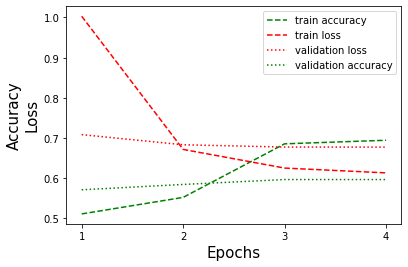

In [87]:
# accuracy score
result = ii.np.round(model.predict(X_test)) # use model from the previous step
print(i.accuracy_score(y_test, result))
# plotting 
f.plot_model_history(history)

# POS-tagger

In [ ]:
# https://www.nltk.org/api/nltk.tag.html
from nltk import pos_tag, word_tokenize
nltk.download('averaged_perceptron_tagger')

#only works for english
def pos_tag_stringlist(strlist, shouldTokenize):
    pos_tagged_strlist = []
    if shouldTokenize: 
        for str in strlist: pos_tagged_strlist.append(pos_tag(word_tokenize(str)))
    else: 
        for str in strlist: pos_tagged_strlist.append(pos_tag(str))
    return pos_tagged_strlist

# STEPS

In [ ]:
# define the two model
### baseline, Hugging Face

In [ ]:
# LOG the results in pandas Dataframe

In [2]:
# STEPS ORDER for Preprocessing
# 1. Basic preprocessing - Should be the first step
# 2. Grammar Correction
# 3. Simplify Contractions
# 4. Lemmatize 
# 5. Remove stop words

In [17]:
# TODO: 
# 2. Define the technical parameters of the basic NN
## post tagging 
## 10k same sentence 
## first 50 word
## 
#### BASE RNN vs Hugging Face 
# simple pandas dataframe - Columns are preproc methods, 1,0,1, accuracy, etc  
# 4. Best vs Worst Accuracy settings test on bigger corpus # Bigger test, Train? Dev set ?

In [18]:
# Grid search

In [275]:
def grid_search(train_list, test_list, y_train, y_test):
    simp_contr = [0, 1]
    gram_cor = [0, 1]
    simp_neg = [0, 1]
    lemma = [0, 1]
    rem_stop = [0, 1]
    basic_preprocessing = 1
    list_of_data = []
    for z in simp_contr:
        for x in gram_cor:
            for c in simp_neg:
                for v in lemma:
                    for b in rem_stop:
                        train = train_list
                        test = test_list
                        if z == 1: # contractions
                            train = f.simplify_contraction(train)
                            test = f.simplify_contraction(test)
                        if basic_preprocessing == 1: # basic preprocessing
                            train = pp.basic_preprocess(train)
                            test = pp.basic_preprocess(test)
                        if x == 1: # grammar correction 
                            train = pp.grammar_corrector(train)
                            test = pp.grammar_corrector(test)
                        if c == 1: # Simnplyfy Negotiation 
                            train = f.simplify_negation(train)
                            test = f.simplify_negation(test)
                        if v == 1: # Lemmatize 
                            train = f.lemmatize_sentencelist(train)
                            test = f.lemmatize_sentencelist(test)
                        if b == 1: # Remove stop words
                            train = pp.remove_stop_words(train)
                            test = pp.remove_stop_words(test)

                        list_of_data.append([[z, basic_preprocessing, x, c, v, b], train, test]) #
    return list_of_data, y_train, y_test

In [228]:
data_sets, y_train, y_test = grid_search(X_train, X_test, y_train, y_test)

In [270]:
### INIT RESULTS
results, time = f.init_log_for_training()

for data_set in data_sets:
    # Tokenizer
    labels = data_set[0]

    tokenizer = pp.tokenizer_init(data_set[1], data_set[2])
    Train = tokenizer.texts_to_sequences(data_set[1])
    Test = tokenizer.texts_to_sequences(data_set[2])
        # Sequencer 
    X_train_p = pp.sequence_pad(Train) # there are several attributes which can be defined, basic = first 50 words 
    X_test_p = pp.sequence_pad(Test)
        
        # TRAIN
    #print("shapes: ", X_train_p.shape, X_test_p.shape)
    history, model = nn.RNN_train(X_train_p, y_train, X_test_p, y_test, tokenizer)
     ### LOGGING INIT - RNN
    # GET the index of the highest test ACCURACY where the RNN model stopped to TRAIN
    max_value = max(history.history['val_accuracy'])
    max_index = history.history['val_accuracy'].index(max_value)
    # append
    
    new_row = {'Running ID':save_time, 
           "Model Name":"RNN", 
          "Expand Contractions":labels[0],
          "Basic Preprocessing":labels[1],
          "Grammar Correction":labels[2],
           "Simplify Negotiations": labels[3],
          "Lemmatize": labels[4],
          "Remove Stop Words": labels[5],
          "No. of Sentences": len(data_sets[c][1]),
          "Train Accuracy STOP": history.history['accuracy'][max_index],
          "Test Accuracy STOP": history.history['val_accuracy'][max_index],
          "Train Loss STOP": history.history['loss'][max_index],
          "Test Loss STOP": history.history['val_loss'][max_index]}
    
    results = results.append(new_row, ignore_index=True)
    # maybe we dont need it in every round but how knows
    try:
        results.to_csv("results/results_"+time+".csv")
    except: 
        continue 
    
# save results again
results.to_csv("results/results_"+time+".csv") 

Epoch 1/10
20/20 [==============================] - 5s 182ms/step - loss: 1.2024 - accuracy: 0.5200 - val_loss: 0.7496 - val_accuracy: 0.5900 - lr: 0.0010
Epoch 2/10
20/20 [==============================] - ETA: 0s - loss: 0.6551 - accuracy: 0.5850
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
20/20 [==============================] - 3s 173ms/step - loss: 0.6551 - accuracy: 0.5850 - val_loss: 0.6745 - val_accuracy: 0.5920 - lr: 0.0010
Epoch 3/10
20/20 [==============================] - ETA: 0s - loss: 0.6177 - accuracy: 0.6140
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
20/20 [==============================] - 4s 179ms/step - loss: 0.6177 - accuracy: 0.6140 - val_loss: 0.6722 - val_accuracy: 0.5970 - lr: 2.0000e-04
Epoch 4/10
20/20 [==============================] - ETA: 0s - loss: 0.6105 - accuracy: 0.6370
Epoch 4: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
20/20 [==============================] - 

20/20 [==============================] - ETA: 0s - loss: 0.5840 - accuracy: 0.7700
Epoch 6: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.
20/20 [==============================] - 4s 214ms/step - loss: 0.5840 - accuracy: 0.7700 - val_loss: 0.6650 - val_accuracy: 0.6070 - lr: 1.6000e-06
Epoch 7/10
20/20 [==============================] - ETA: 0s - loss: 0.5839 - accuracy: 0.7700
Epoch 7: ReduceLROnPlateau reducing learning rate to 6.400000529538374e-08.
20/20 [==============================] - 5s 240ms/step - loss: 0.5839 - accuracy: 0.7700 - val_loss: 0.6650 - val_accuracy: 0.6070 - lr: 3.2000e-07
Epoch 7: early stopping
Epoch 1/10
20/20 [==============================] - 7s 230ms/step - loss: 1.0389 - accuracy: 0.5080 - val_loss: 0.6970 - val_accuracy: 0.5760 - lr: 0.0010
Epoch 2/10
20/20 [==============================] - ETA: 0s - loss: 0.6521 - accuracy: 0.5890
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
20/20 [==================

20/20 [==============================] - 4s 194ms/step - loss: 0.6335 - accuracy: 0.6550 - val_loss: 0.6843 - val_accuracy: 0.5780 - lr: 1.6000e-06
Epoch 7/10
20/20 [==============================] - ETA: 0s - loss: 0.6335 - accuracy: 0.6550
Epoch 7: ReduceLROnPlateau reducing learning rate to 6.400000529538374e-08.
20/20 [==============================] - 4s 193ms/step - loss: 0.6335 - accuracy: 0.6550 - val_loss: 0.6843 - val_accuracy: 0.5780 - lr: 3.2000e-07
Epoch 7: early stopping
Epoch 1/10
20/20 [==============================] - 6s 214ms/step - loss: 1.5412 - accuracy: 0.5430 - val_loss: 0.6849 - val_accuracy: 0.5850 - lr: 0.0010
Epoch 2/10
20/20 [==============================] - ETA: 0s - loss: 0.6504 - accuracy: 0.6090
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
20/20 [==============================] - 4s 198ms/step - loss: 0.6504 - accuracy: 0.6090 - val_loss: 0.6644 - val_accuracy: 0.6120 - lr: 0.0010
Epoch 3/10
20/20 [======================

20/20 [==============================] - 3s 172ms/step - loss: 0.5737 - accuracy: 0.7810 - val_loss: 0.6518 - val_accuracy: 0.6370 - lr: 8.0000e-06
Epoch 6/10
20/20 [==============================] - ETA: 0s - loss: 0.5730 - accuracy: 0.7820
Epoch 6: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.
20/20 [==============================] - 3s 173ms/step - loss: 0.5730 - accuracy: 0.7820 - val_loss: 0.6517 - val_accuracy: 0.6370 - lr: 1.6000e-06
Epoch 7/10
20/20 [==============================] - ETA: 0s - loss: 0.5728 - accuracy: 0.7820
Epoch 7: ReduceLROnPlateau reducing learning rate to 6.400000529538374e-08.
20/20 [==============================] - 3s 171ms/step - loss: 0.5728 - accuracy: 0.7820 - val_loss: 0.6517 - val_accuracy: 0.6370 - lr: 3.2000e-07
Epoch 7: early stopping
Epoch 1/10
20/20 [==============================] - 5s 190ms/step - loss: 1.0036 - accuracy: 0.5200 - val_loss: 0.7364 - val_accuracy: 0.5710 - lr: 0.0010
Epoch 2/10
20/20 [===================

20/20 [==============================] - ETA: 0s - loss: 0.5978 - accuracy: 0.7720
Epoch 6: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.
20/20 [==============================] - 4s 197ms/step - loss: 0.5978 - accuracy: 0.7720 - val_loss: 0.6626 - val_accuracy: 0.6200 - lr: 1.6000e-06
Epoch 6: early stopping
Epoch 1/10
20/20 [==============================] - 6s 228ms/step - loss: 0.8834 - accuracy: 0.4990 - val_loss: 0.6878 - val_accuracy: 0.5740 - lr: 0.0010
Epoch 2/10
20/20 [==============================] - ETA: 0s - loss: 0.6559 - accuracy: 0.6140
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
20/20 [==============================] - 4s 208ms/step - loss: 0.6559 - accuracy: 0.6140 - val_loss: 0.6774 - val_accuracy: 0.5900 - lr: 0.0010
Epoch 3/10
20/20 [==============================] - ETA: 0s - loss: 0.6159 - accuracy: 0.6900
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
20/20 [=====================

KeyboardInterrupt: 

# Leave it in here for experimenting purpose: 

In [248]:
'''### INIT RESULTS
results, time = f.init_log_for_training()
for c in range(2):
    # Tokenizer
    labels = data_sets[c][0]
    print("##### Combination\n: ", data_sets[c][0])
    tokenizer = pp.tokenizer_init(data_sets[c][1], data_sets[c][2])
    Train = tokenizer.texts_to_sequences(data_sets[c][1])
    Test = tokenizer.texts_to_sequences(data_sets[c][2])
        # Sequencer 
    X_train_p = pp.sequence_pad(Train) # there are several attributes which can be defined, basic = first 50 words 
    X_test_p = pp.sequence_pad(Test)
        
    # TRAIN RNN
    history, model = nn.RNN_train(X_train_p, y_train, X_test_p, y_test, tokenizer)

    ### LOGGING INIT - RNN
    # GET the index of the highest test ACCURACY where the RNN model stopped to TRAIN
    max_value = max(history.history['val_accuracy'])
    max_index = history.history['val_accuracy'].index(max_value)
    # append
    
    new_row = {'Running ID':save_time, 
           "Model Name":"RNN", 
          "Expand Contractions":labels[0],
          "Basic Preprocessing":labels[1],
          "Grammar Correction":labels[2],
           "Simplify Negotiations": labels[3],
          "Lemmatize": labels[4],
          "Remove Stop Words": labels[5],
          "No. of Sentences": len(data_sets[c][1]),
          "Train Accuracy STOP": history.history['accuracy'][max_index],
          "Test Accuracy STOP": history.history['val_accuracy'][max_index],
          "Train Loss STOP": history.history['loss'][max_index],
          "Test Loss STOP": history.history['val_loss'][max_index]}
    
    results = results.append(new_row, ignore_index=True)
    
# save results
results.to_csv("results/results_"+time+".csv") '''

##### Combination
:  [0, 1, 0, 0, 0, 0]
Epoch 1/10
20/20 [==============================] - 5s 175ms/step - loss: 1.2002 - accuracy: 0.5320 - val_loss: 0.6855 - val_accuracy: 0.5870 - lr: 0.0010
Epoch 2/10
20/20 [==============================] - ETA: 0s - loss: 0.6491 - accuracy: 0.5910
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
20/20 [==============================] - 3s 149ms/step - loss: 0.6491 - accuracy: 0.5910 - val_loss: 0.6657 - val_accuracy: 0.6240 - lr: 0.0010
Epoch 3/10
20/20 [==============================] - ETA: 0s - loss: 0.6129 - accuracy: 0.7610
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
20/20 [==============================] - 3s 149ms/step - loss: 0.6129 - accuracy: 0.7610 - val_loss: 0.6637 - val_accuracy: 0.6260 - lr: 2.0000e-04
Epoch 4/10
20/20 [==============================] - ETA: 0s - loss: 0.6038 - accuracy: 0.7640
Epoch 4: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
2